# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import deepdish as dd
from jupyterthemes import jtplot
jtplot.style('default')

## List the parameters
First, we list our fitting parameters.

In [2]:
fp = byp.param_list()
fp.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=15,units='arb.')
fp.add_fit_param(name='n',val_range=[1,2],length=15)

We can inspect the `param_list` object and see what kind of information is inside...

In [3]:
fp.fit_params

[{'edges': array([   10.        ,    13.59356391,    18.47849797,    25.11886432,
            34.14548874,    46.41588834,    63.09573445,    85.76958986,
           116.59144012,   158.48931925,   215.443469  ,   292.86445646,
           398.10717055,   541.16952655,   735.64225446,  1000.        ]),
  'length': 15,
  'min_width': 1.0311772745930552,
  'name': 'Bp',
  'spacing': 'log',
  'units': 'arb.',
  'val_range': [10, 1000],
  'vals': array([  11.65914401,   15.84893192,   21.5443469 ,   29.28644565,
           39.81071706,   54.11695265,   73.56422545,  100.        ,
          135.93563909,  184.78497974,  251.18864315,  341.45488738,
          464.15888336,  630.95734448,  857.69589859])},
 {'edges': array([ 1.        ,  1.06666667,  1.13333333,  1.2       ,  1.26666667,
          1.33333333,  1.4       ,  1.46666667,  1.53333333,  1.6       ,
          1.66666667,  1.73333333,  1.8       ,  1.86666667,  1.93333333,  2.        ]),
  'length': 15,
  'min_width': 0.0066666666666

Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions. We won't be varying light intensity here, so we only need voltage and temperature.

In [4]:
ec = ['V','T']

In [5]:
m = bym.model(params=fp,ec=ec,output_var='J')

In [6]:
m.probs.points.head(11)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub
0,11.659144,10.0,13.593564,1.033333,1.000000,1.066667,1.0,0.004444,0
1,11.659144,10.0,13.593564,1.100000,1.066667,1.133333,1.0,0.004444,0
2,11.659144,10.0,13.593564,1.166667,1.133333,1.200000,1.0,0.004444,0
3,11.659144,10.0,13.593564,1.233333,1.200000,1.266667,1.0,0.004444,0
4,11.659144,10.0,13.593564,1.300000,1.266667,1.333333,1.0,0.004444,0
5,11.659144,10.0,13.593564,1.366667,1.333333,1.400000,1.0,0.004444,0
6,11.659144,10.0,13.593564,1.433333,1.400000,1.466667,1.0,0.004444,0
7,11.659144,10.0,13.593564,1.500000,1.466667,1.533333,1.0,0.004444,0
8,11.659144,10.0,13.593564,1.566667,1.533333,1.600000,1.0,0.004444,0
9,11.659144,10.0,13.593564,1.633333,1.600000,1.666667,1.0,0.004444,0


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

In [7]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.05)
T = [float(t) for t in np.arange(150,301,50)]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    for v in V:
        data.append([v,t,compute_ID({'V':v,'T':t},params)])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J'])
#dd.io.save('obs_data.h5',data)

In [8]:
m.attach_observations(fpath='obs_data.h5')

Identified experimental conditions as ['V', 'T']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.


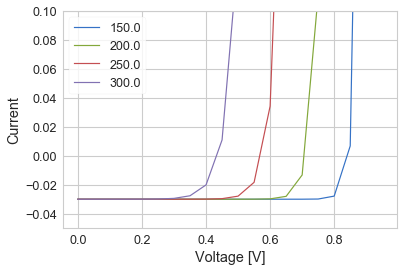

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data.iloc[len(V)*i:len(V)*(i+1)]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

In [10]:
#m.obs_data.head()

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [11]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

That's it! When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [12]:
m.model_data.head(10)

,Bp,J,T,V,n
0,11.659144,-0.03,150.0,0.00,1.033333
1,11.659144,-0.03,150.0,0.05,1.033333
2,11.659144,-0.03,150.0,0.10,1.033333
3,11.659144,-0.03,150.0,0.15,1.033333
4,11.659144,-0.03,150.0,0.20,1.033333
5,11.659144,-0.03,150.0,0.25,1.033333
6,11.659144,-0.03,150.0,0.30,1.033333
7,11.659144,-0.03,150.0,0.35,1.033333
8,11.659144,-0.03,150.0,0.40,1.033333
9,11.659144,-0.03,150.0,0.45,1.033333


In [13]:
m.calc_model_gradients()

## Drop that Bayes!

In [14]:
m.probs.uniformize() #not actually necessary but good for rerunning when numerics problems strike
m.run()

(0, V       0.850000
T     300.000000
J    3568.727199
Name: 77, dtype: float64)
(1, V      0.30
T    200.00
J     -0.03
Name: 26, dtype: float64)
(2, V      0.05
T    200.00
J     -0.03
Name: 21, dtype: float64)
(3, V      0.00
T    200.00
J     -0.03
Name: 20, dtype: float64)
(4, V      0.700000
T    200.000000
J     -0.013284
Name: 34, dtype: float64)
(5, V      0.20
T    150.00
J     -0.03
Name: 4, dtype: float64)
(6, V      0.05
T    250.00
J     -0.03
Name: 41, dtype: float64)
(7, V      0.550000
T    200.000000
J     -0.029972
Name: 31, dtype: float64)
Fed in 8 points and now time to subdivide!


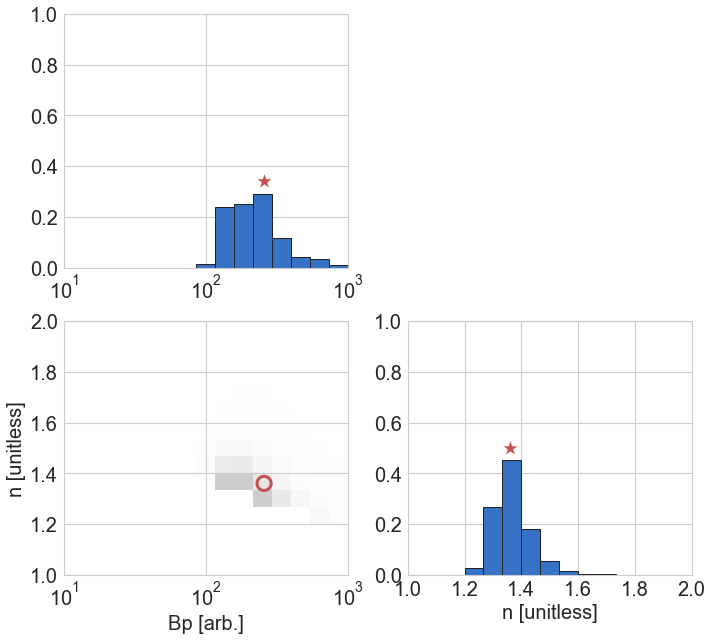

In [15]:
m.visualize_probs(true_vals=params)

In [16]:
m.probs.most_probable(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,new,prob,num_sub,start_ind,end_ind
140,184.784980,158.489319,215.443469,1.366667,1.333333,1.400000,1.0,0.163872,0,11200,11279
125,135.935639,116.591440,158.489319,1.366667,1.333333,1.400000,1.0,0.163460,0,10000,10079
154,251.188643,215.443469,292.864456,1.300000,1.266667,1.333333,1.0,0.161821,0,12320,12399
155,251.188643,215.443469,292.864456,1.366667,1.333333,1.400000,1.0,0.080997,0,12400,12479
169,341.454887,292.864456,398.107171,1.300000,1.266667,1.333333,1.0,0.069891,0,13520,13599
141,184.784980,158.489319,215.443469,1.433333,1.400000,1.466667,1.0,0.061473,0,11280,11359
126,135.935639,116.591440,158.489319,1.433333,1.400000,1.466667,1.0,0.058672,0,10080,10159
156,251.188643,215.443469,292.864456,1.433333,1.400000,1.466667,1.0,0.031018,0,12480,12559
170,341.454887,292.864456,398.107171,1.366667,1.333333,1.400000,1.0,0.029428,0,13600,13679
184,464.158883,398.107171,541.169527,1.300000,1.266667,1.333333,1.0,0.024811,0,14720,14799


In [17]:
m.subdivide()

32 box(es) with probability > 0.001 and 19 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_1.h5.


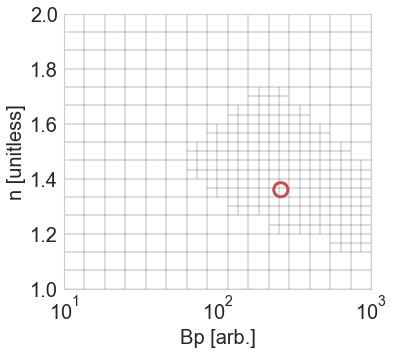

In [18]:
m.visualize_grid(true_vals=params)

In [19]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [20]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [21]:
m.attach_model(mode='add',fpath='new_sim_data_1.h5')

In [22]:
m.calc_model_gradients()

In [23]:
m.probs.uniformize()
m.run(th_pm=0.95,th_pv=0.02)

(0, V      0.30
T    200.00
J     -0.03
Name: 26, dtype: float64)
(1, V      0.50
T    150.00
J     -0.03
Name: 10, dtype: float64)
(2, V      0.05
T    200.00
J     -0.03
Name: 21, dtype: float64)
(3, V      0.55
T    150.00
J     -0.03
Name: 11, dtype: float64)
(4, V      0.250000
T    300.000000
J     -0.029862
Name: 65, dtype: float64)
(5, V      0.200000
T    300.000000
J     -0.029967
Name: 64, dtype: float64)
(6, V      0.750000
T    300.000000
J    207.593631
Name: 75, dtype: float64)
(7, V      0.350000
T    300.000000
J     -0.027622
Name: 67, dtype: float64)
(8, V      0.40
T    200.00
J     -0.03
Name: 28, dtype: float64)
(9, V      0.700000
T    150.000000
J     -0.029993
Name: 14, dtype: float64)
Fed in 10 points and now time to subdivide!


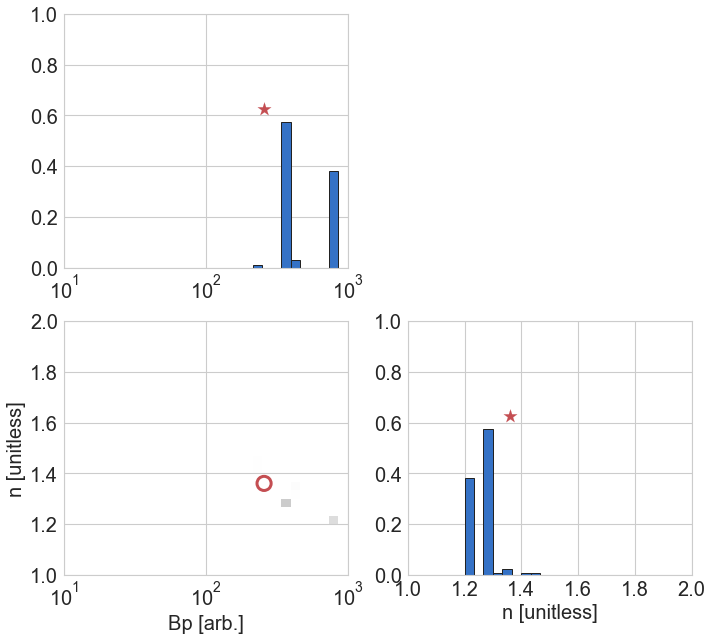

In [24]:
m.visualize_probs(true_vals=params)

In [25]:
m.probs.most_probable(10)

,Bp,Bp_max,Bp_min,end_ind,n,n_max,n_min,new,num_sub,prob,start_ind
270,368.694506,398.107171,341.454887,23919,1.283333,1.300000,1.266667,1.0,1,0.575875,23840
350,794.328235,857.695899,735.642254,28879,1.216667,1.233333,1.200000,1.0,1,0.380125,28800
286,429.866235,464.158883,398.107171,25199,1.350000,1.366667,1.333333,1.0,1,0.024067,25120
214,232.630507,251.188643,215.443469,20639,1.450000,1.466667,1.433333,1.0,1,0.007040,20560
285,429.866235,464.158883,398.107171,25119,1.316667,1.333333,1.300000,1.0,1,0.005312,25040
213,232.630507,251.188643,215.443469,20559,1.416667,1.433333,1.400000,1.0,1,0.005142,20480
238,271.227258,292.864456,251.188643,21999,1.483333,1.500000,1.466667,1.0,1,0.000447,21920
371,926.118728,1000.000000,857.695899,29759,1.250000,1.266667,1.233333,1.0,1,0.000316,29680
176,171.132830,184.784980,158.489319,18239,1.450000,1.466667,1.433333,1.0,1,0.000315,18160
193,199.526231,215.443469,184.784980,18959,1.283333,1.300000,1.266667,1.0,1,0.000252,18880


In [26]:
m.subdivide()

6 box(es) with probability > 0.001 and 18 neighboring boxes subdivided!
New model points to simulate are saved in the file new_sim_points_2.h5.


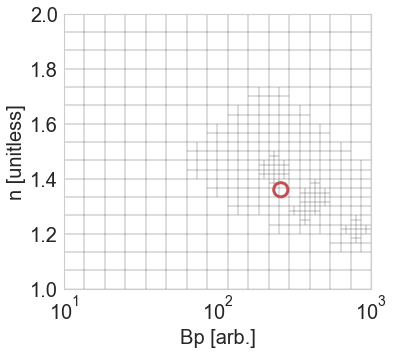

In [27]:
m.visualize_grid(true_vals=params)

In [ ]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.param_names])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.param_names)
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='add',fpath='new_sim_data_2.h5')
m.calc_model_gradients()

In [ ]:
m.probs.uniformize()
m.run(th_pm=0.98,th_pv=0.015)

In [ ]:
m.visualize_probs(true_vals=params)

In [ ]:
m.probs.most_probable(5)

In [ ]:
m.probs.params